In [39]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scikits.odes.ode import ode
import time
import seaborn as sns

In [22]:
#Import local functions
def activation(x, k, theta, n):
    return (k*(x/theta)**n)/(1+(x/theta)**n)

def repression(x, k, theta, n):
    return k/(1+(x/theta)**n)

def nonlinearity(x, kc, km):
    return (kc*x)/(km+x)

def loss_biological(j1, j2, alpha1, alpha2):
    """Computes scalarized loss including genetic constraint and product production"""
    loss = alpha1*j1 + alpha2*j2
    return j1, j2, loss

In [23]:
def dual_control(t, y, ydot):
    ydot[0] = Vin - lam*y[0] - e0*nonlinearity(y[0], kc, km) - lam*y[1]
    ydot[1] = y[2]*nonlinearity(y[0], kc, km) - y[3]*nonlinearity(y[1], kc, km) - lam*y[1]
    ydot[2] = repression(y[1], k1, theta1, n1) - lam*y[2]
    ydot[3] = activation(y[1], k2, theta2, n2) - lam*y[3]
    ydot[4] = (Vin -  y[3]*nonlinearity(y[1], kc, km))**2
    ydot[5] = repression(y[1], k1, theta1, n1) + activation(y[1], k2, theta2, n2)

In [24]:
#Establish hyperparameters
alpha1 = 1E-5
alpha2 = 1E-2

int_time = 5E4
t = np.linspace(0, int_time, 100) 
y0 = np.array([2290., 0., 0., 0., 0., 0.]) 

#Constants
Vin = 1
e0 = 0.0467 
lam = 1.93E-4 
#Assume equal kinetics for all three enzymes
kc = 12 
km = 10


In [30]:
ns = [1, 2, 3, 4]
thetas = [0.01, 0.05, 0.1, 0.5, 1, 2.5, 5, 7.5, 10, 100]
ks = [1E-7, 5E-6, 1E-6, 5E-5, 1E-5, 5E-4, 1E-4, 1E-3, 1E-3]

In [26]:
def solve_point(x):
    n1, n2, theta1, theta2, k1, k2 = x
    solution = ode('cvode', dual_control, old_api=False).solve(t, y0)
    j1, j2 = solution.values.y[-1, -2:]
    j1, j2, loss = loss_biological(j1, j2, alpha1=alpha1, alpha2=alpha2)
    return j1, j2, loss

In [31]:
results = pd.DataFrame(columns=['n1', 'n2', 'theta1', 'theta2', 'k1', 'k2', 'elapsed_time', 'j1', 'j2', 'loss'])
for n1 in ns:
    for n2 in ns:
        for k1 in ks:
            for k2 in ks:
                for theta1 in thetas:
                    for theta2 in thetas:
                        start_time = time.time()
                        j1, j2, loss = solve_point([n1, n2, theta1, theta2, k1, k2])
                        elapsed_time = time.time()-start_time
                        row = [n1, n2, theta1, theta2, k1, k2, elapsed_time, j1, j2, loss]
                        results.loc[len(results)] = row

In [33]:
results.to_csv('6d_landscape_sundials.csv')

<AxesSubplot:xlabel='loss', ylabel='Density'>

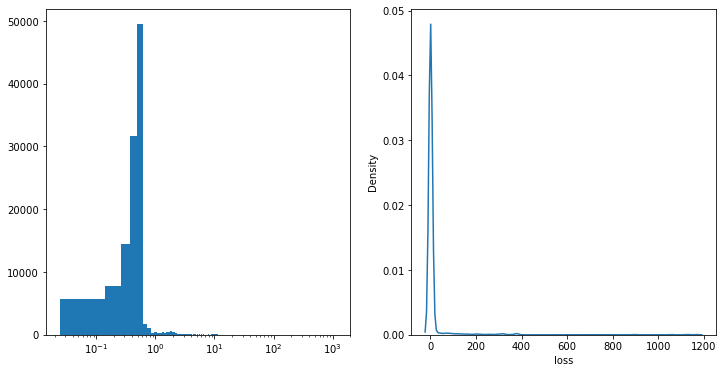

In [47]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
ax = axs[0]
ax.hist(results.loss, bins=10000)
ax.set_xscale('log')

ax = axs[1]
sns.kdeplot(results.loss, ax=ax)


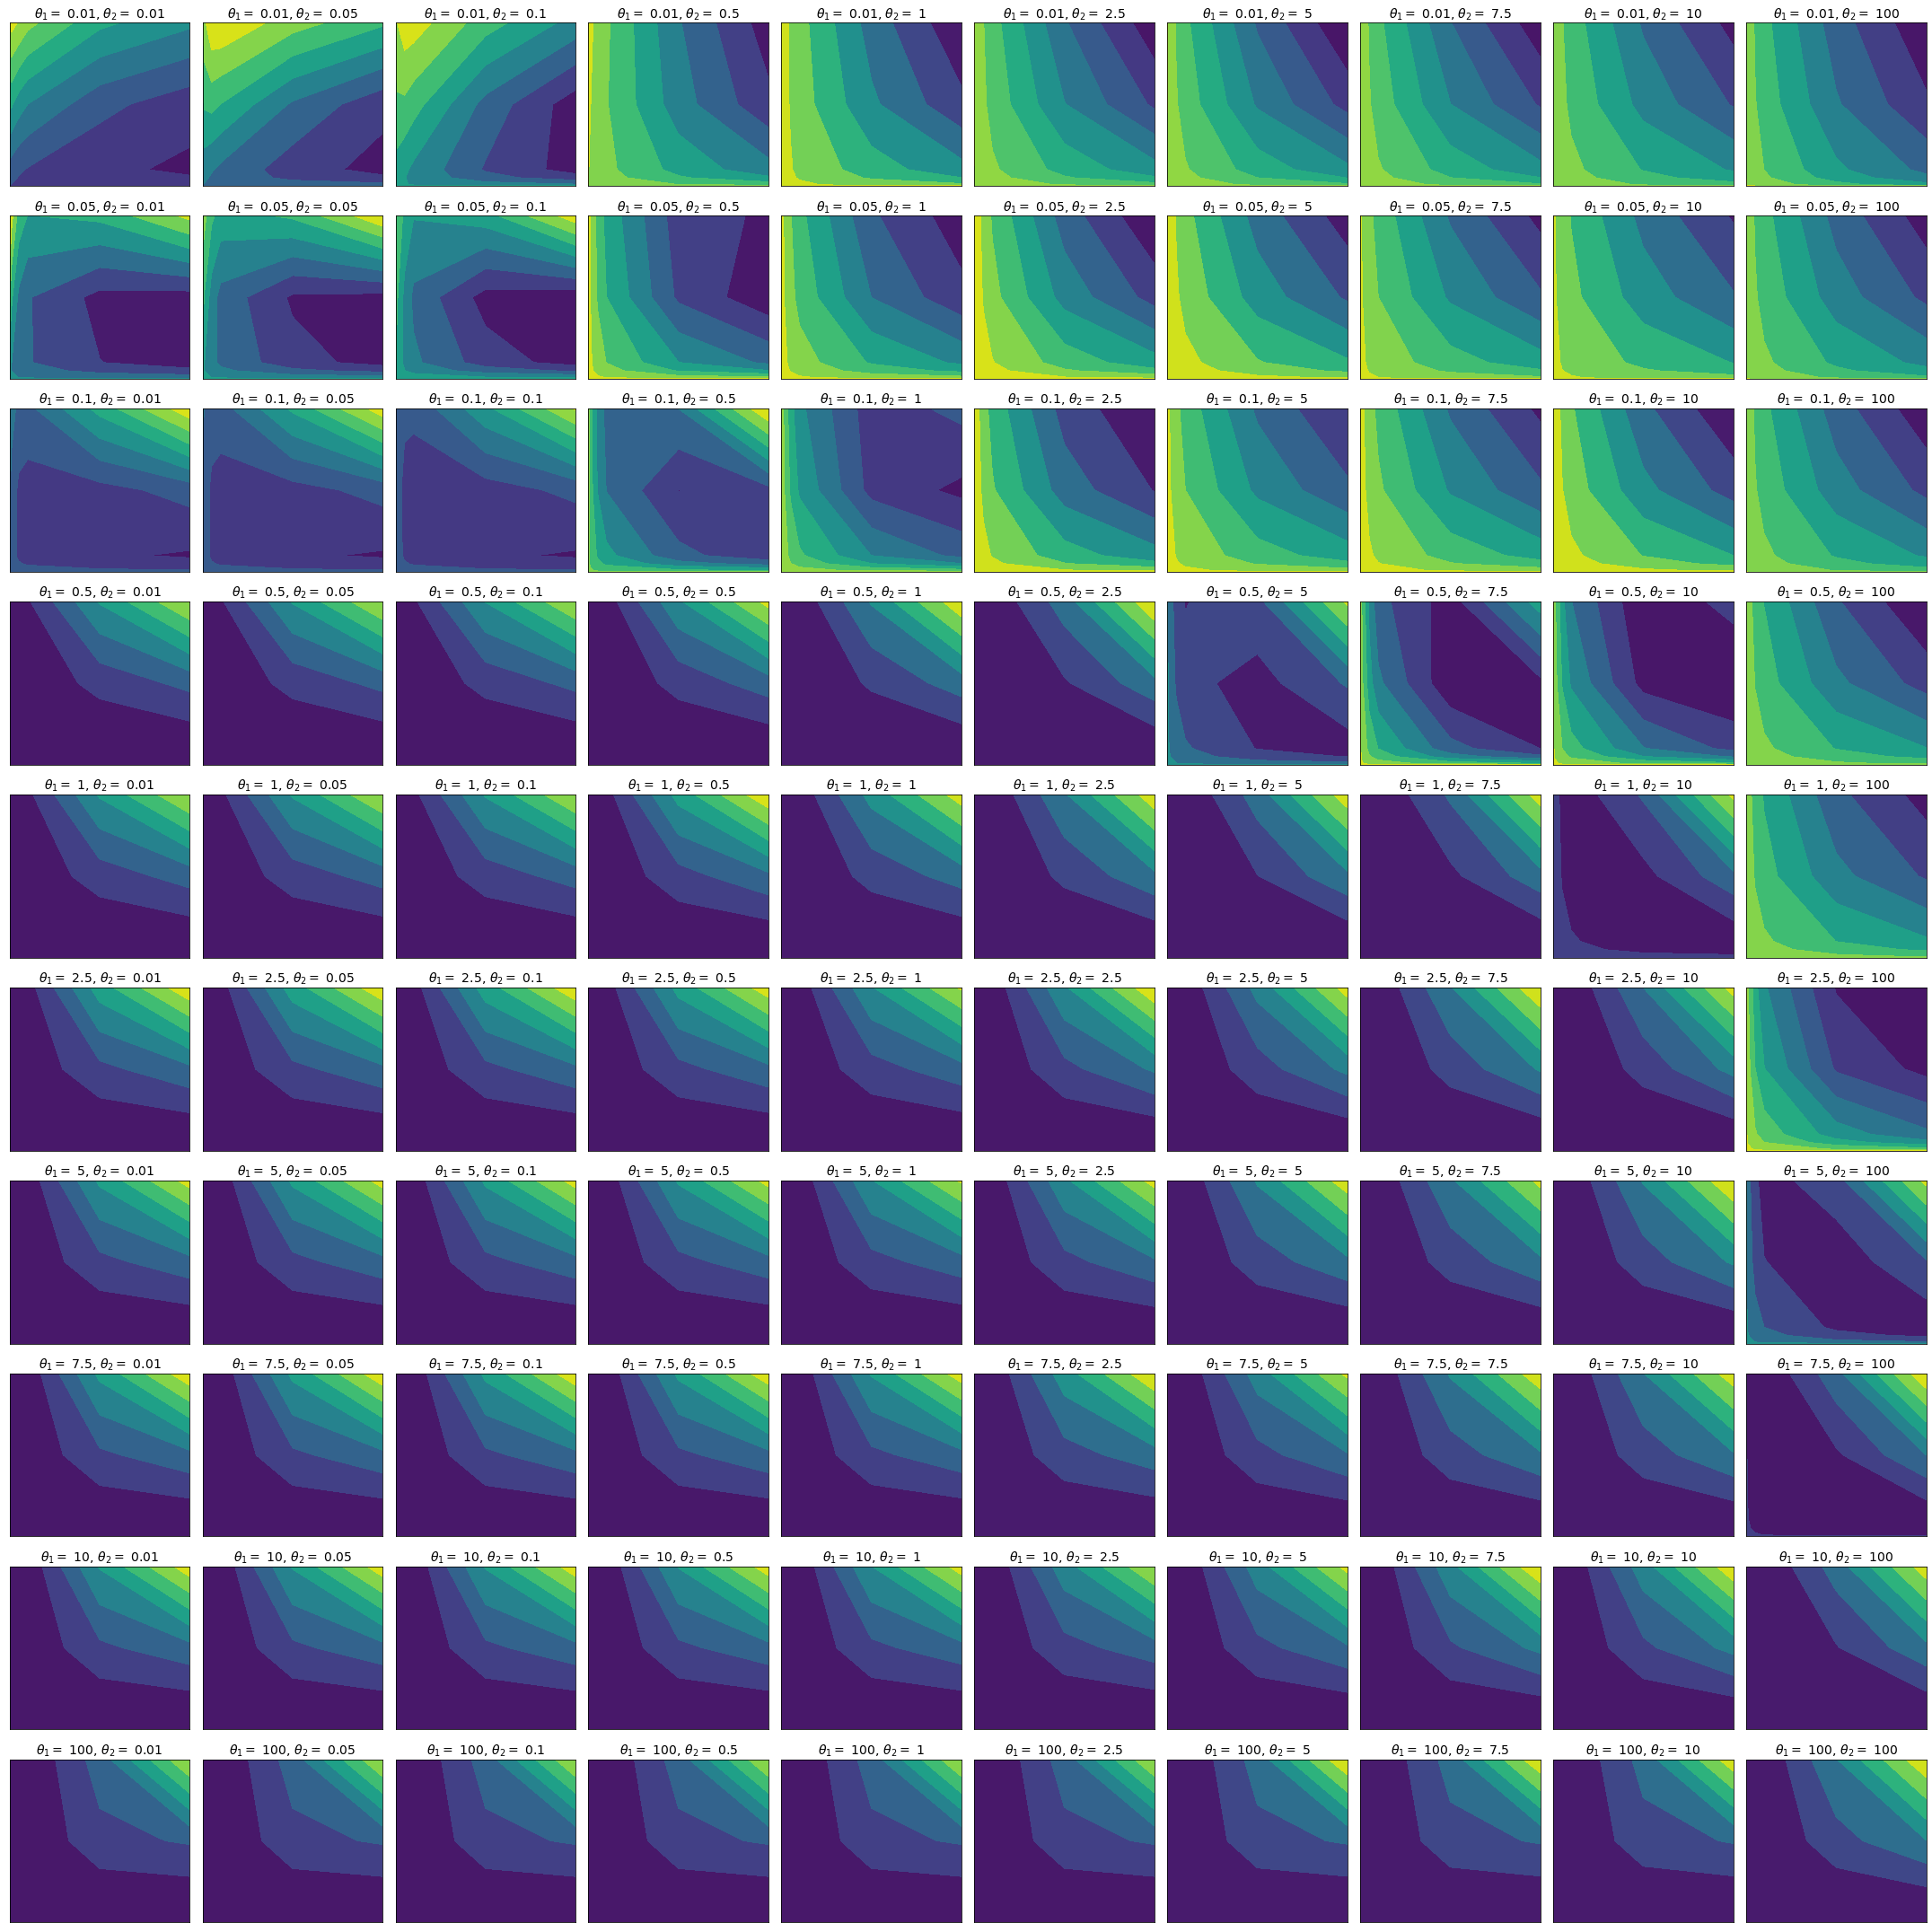

In [49]:
#Try to regenerate plots from solvers
doubles = results.loc[results.n1 == 2].loc[results.n2 == 2]

fig, axs = plt.subplots(10, 10, figsize=(30,30))

for i in range(10):
    for j in range(10):
        ax = axs[i][j]
        theta1 = thetas[i]
        theta2 = thetas[j]
        d = doubles.loc[doubles.theta1 == theta1].loc[doubles.theta2 ==theta2]
        k1_unique = np.sort(d.k1.unique())
        k2_unique = np.sort(d.k2.unique())
        k1s, k2s = np.meshgrid(k1_unique, k2_unique)
        loss = d.pivot_table(index='k1', columns='k2', values='loss').T.values
        contour = ax.contourf(k1s,k2s,loss)
        ax.set_title(rf'$\theta_1 = $ {round(theta1, 2)}, $\theta_2 = $ {round(theta2, 2)}', fontsize=14)
        ax.set_xticks([])
        ax.set_yticks([])
        #fig.colorbar(contour, ax=ax)

fig.tight_layout()

In [50]:
results.loss.min()

0.024294415488327115